In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import time

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline

%matplotlib inline

from sklearn.model_selection import train_test_split



In [3]:
# læs data 
df_est = pd.read_pickle('job_kurser.pkl')

print(df_est.head(2))


# def dan_xy(index) :
#     y = np.array((np.log(df_est.iloc[index])))
#     X = np.array((np.log(df_est.iloc[index+14]))).reshape(-1, 1)
#     return X, y

# X, y = dan_xy(7)
# X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
# X_train, X_eval, y_train, y_eval = train_test_split(X_dev, y_dev, test_size=.25, random_state=2)

# X_train


             Carlsberg  Coloplast  Danske Bank         DSV  Jyske Bank  \
Date                                                                     
2007-01-31  456.189545    101.200   235.768773  102.263636  397.664091   
2007-02-28  480.336250    100.815   247.720700   99.975000  428.416050   

               Nordea  Novo Nordisk   Novozymes     Vestas        Tryg  \
Date                                                                     
2007-01-31  89.079545     48.022727  102.440909  90.772727  242.977273   
2007-02-28  90.075000     51.272500   99.295000  93.835000  277.125000   

              ...     DSV_jobs  Jyske_Bank_jobs  Nordea_jobs  \
Date          ...                                              
2007-01-31    ...           12               30           34   
2007-02-28    ...           13               28           46   

            Novo_Nordisk_jobs  Novozymes_jobs  Vestas_jobs  Tryg_jobs  \
Date                                                                    
200

## Structure data

In [123]:
col_kurs = list(df_est.iloc[:,:13])
col_post = list(df_est.iloc[:,-13:])
print(col_kurs)
l = len(df_est)

container = pd.DataFrame(columns=['stock_price', 'job_postings', 'company'])
for i in range(len(col_kurs)) :
    yserie = np.log(df_est[col_kurs[i]]).shift(periods=-1)
    xserie = (df_est[col_post[i]])
    tmp = pd.DataFrame(pd.concat([yserie.iloc[:-1], xserie.iloc[:-1]], axis=1, ignore_index=True))
    tmp.columns=(['stock_price', 'job_postings'])
    tmp['company']=col_kurs[i]
    container = pd.concat([container, tmp], axis=0, ignore_index=True)
print(container.head())

['Carlsberg', 'Coloplast', 'Danske Bank', 'DSV', 'Jyske Bank', 'Nordea', 'Novo Nordisk', 'Novozymes', 'Vestas', 'Tryg', 'H. Lundbeck', 'Alm. Brand', 'SAS']
   stock_price job_postings    company
0     6.174486           22  Carlsberg
1     6.154184            8  Carlsberg
2     6.185821           16  Carlsberg
3     6.270629           30  Carlsberg
4     6.275957            9  Carlsberg


In [124]:
container0 = container.fillna(0)#nan_to_num(container)
#banks=['Carlsberg']#, 'Danske Bank', 'DSV', 'Jyske Bank', 'Nordea', 'Vestas', 'Tryg', 'Alm. Brand', 'H. Lundbeck']
banks=['Nordea', 'Danske Bank', 'Jyske Bank']
df_bank = container0[container0.company.isin(banks)]

#input_data = pd.get_dummies(container0, columns=['company'])
input_data = pd.get_dummies(df_bank, columns=['company'])
print(input_data.head())
features = list(input_data.iloc[:,1:])

input_data_l1 = input_data.shift()

# dan X og y
y = np.array(input_data['stock_price'])
X = np.array(input_data.iloc[:,1:])

# dan training og test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)
y = np.nan_to_num(y, copy=False)



    stock_price  job_postings  company_Danske Bank  company_Jyske Bank  \
94     5.512302          29.0                    1                   0   
95     5.454206          45.0                    1                   0   
96     5.470863          23.0                    1                   0   
97     5.424101          56.0                    1                   0   
98     5.363661          73.0                    1                   0   

    company_Nordea  
94               0  
95               0  
96               0  
97               0  
98               0  
(105, 4) (105,)
(36, 4) (36,)


## Regression

Test data: Mean=4.8484, STD=0.6086 and VAR=0.3704.
Measured data: Mean=4.8513, STD=0.5668 and VAR=0.3213.
The function:
y = 4.769 + 0.2813 * x0 + 0.0382 * x1 + 0.3497 * x2 + -0.3774 * x3

x0 = job_postings
x1 = company_Danske Bank
x2 = company_Jyske Bank
x3 = company_Nordea

R^2 Train: 0.813, test: 0.832
Mean squared error: 0.05385


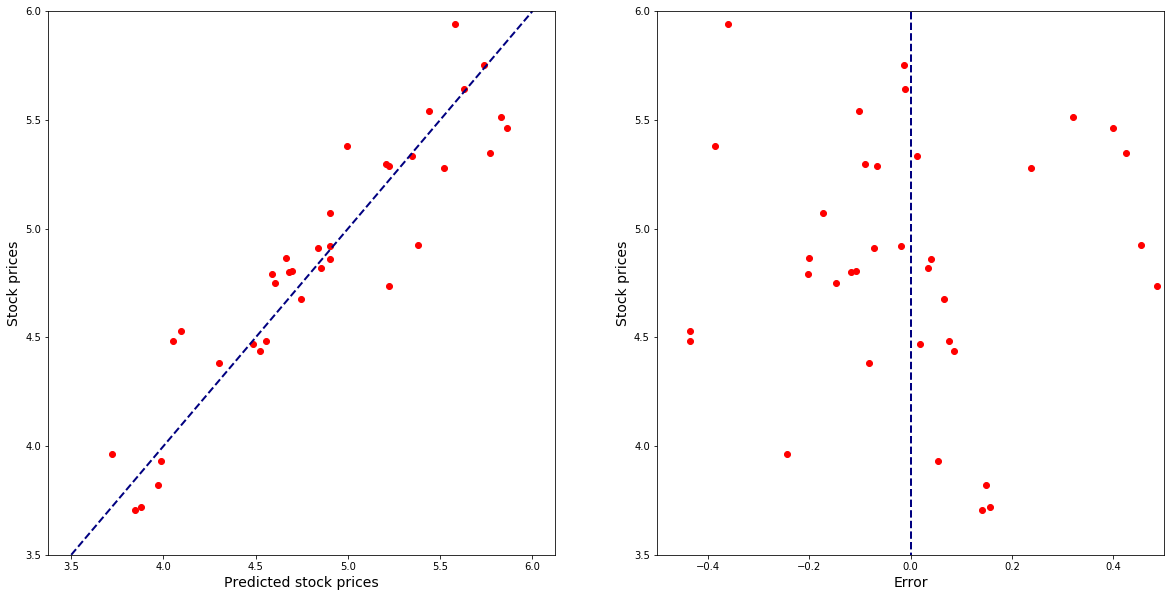

In [149]:
from sklearn.metrics import r2_score

pipe_lr = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

feature_names = pipe_lr.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_lr.named_steps.linearregression.coef_
intercept = pipe_lr.named_steps.linearregression.intercept_

#print("Beta =", pipe_lr.coef_[0])
#print('Alpha = ', pipe_lr.intercept_)

y_dev_hat = pipe_lr.predict(X_dev)
y_test_hat = pipe_lr.predict(X_test)

print("Test data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))
print("Measured data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test), 4), round(np.std(y_test), 4), round(np.var(y_test), 4)))

# print model info
print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
for i in range(len(features)) :
    print(feature_names[i], "=", features[i])
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))
print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))


# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(pipe_lr.predict(X_test), y_test, color='red')
ax[1].scatter((pipe_lr.predict(X_test))-y_test, y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_LinReg_lag(-1)_banks.png')

## Lasso

### Pure lasso

In [225]:
perform = []

alphas = np.logspace(-10,-3,33)

for alpha_ in alphas:
    
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=alpha_, random_state=1))
    pipe_lasso.fit(X_dev, y_dev)
    perform.append([alpha_, np.sqrt(mse(pipe_lasso.predict(X_test),y_test))])
    
pf = pd.DataFrame(perform)
headers = ['alpha', 'RMSE_test']
pf.columns = headers
pf.set_index('alpha')
print(pf)
pf.nsmallest(1, 'RMSE_test')



           alpha  RMSE_test
0   1.000000e-10   0.382083
1   1.654817e-10   0.382083
2   2.738420e-10   0.382083
3   4.531584e-10   0.382083
4   7.498942e-10   0.382083
5   1.240938e-09   0.382083
6   2.053525e-09   0.382083
7   3.398208e-09   0.382083
8   5.623413e-09   0.382083
9   9.305720e-09   0.382083
10  1.539927e-08   0.382083
11  2.548297e-08   0.382083
12  4.216965e-08   0.382083
13  6.978306e-08   0.382083
14  1.154782e-07   0.382083
15  1.910953e-07   0.382083
16  3.162278e-07   0.382084
17  5.232991e-07   0.382084
18  8.659643e-07   0.382084
19  1.433013e-06   0.382085
20  2.371374e-06   0.382085
21  3.924190e-06   0.382087
22  6.493816e-06   0.382089
23  1.074608e-05   0.382093
24  1.778279e-05   0.382099
25  2.942727e-05   0.382109
26  4.869675e-05   0.382126
27  8.058422e-05   0.382154
28  1.333521e-04   0.382201
29  2.206734e-04   0.382279
30  3.651741e-04   0.382411
31  6.042964e-04   0.382637
32  1.000000e-03   0.383028


,alpha,RMSE_test
0,1.000000e-10,0.382083


[5.25834137 5.21049226 6.12478064 5.97940462 6.18582126 6.27062892
 5.83887063 5.86743334 6.33477214 5.54239809 6.0814922  5.95988358]
[6.06771396 6.06771396 6.06771396 6.06771396 6.06771396 6.06771396
 6.06771396 6.06771396 6.06771396 6.06771396 6.06771396 6.06771396] [ 7. 17.  9.  7. 16. 30. 14. 10. 12. 10. 19. 11.]


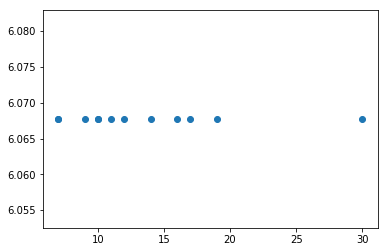

In [229]:
pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=0.382083, random_state=1))
pipe_lasso.fit(X_dev, y_dev)
y_hat = pipe_lasso.predict(X_test)
print(y_test)
print(y_hat, X_test[:,0])
plt.scatter(X_test[:,0], y_hat)


### kFold

In [ ]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=5)

mseCV = []

lambdas =  np.logspace(-5, 4, 12)

for lambda_ in lambdas:
   
    pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=lambda_, random_state=1))    
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_lassoCV.fit(X_train, y_train)
        
        msetest = mse(pipe_lassoCV.predict(X_test), y_test)
        mseCV_.append(msetest)    
    mseCV.append(np.mean(mseCV_))

optimal = pd.Series(mseCV,index=lambdas).nsmallest(1)
print("Optimal lambda")
print("lambda"," "*5, "Mean MSE")
print(optimal)


## Bag of words

### Stopwords

In [119]:
import nltk
stopwords = nltk.corpus.stopwords.words('danish')


### Get data and fit the CountVectorizer

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ny1 = pd.read_pickle('both1.pkl')
ny2 = pd.read_pickle('both2.pkl')
ny4 = pd.read_pickle('both4.pkl')

df_both = pd.concat([ny1, ny2, ny4], axis=0, join='inner', ignore_index=True)

#print("Shape", df_both.shape)
#print("\n")
#print(df_both.head(1), "\n", df_both.tail(2))

desc = df_both.sample(60000, random_state=5)

#print(desc)


t0 = time.time()

count=TfidfVectorizer(ngram_range=(1, 3), max_df=.1, max_features=5000)
bag = count.fit_transform(desc['job_describ'].values)

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.78 sekunder

Procestid er 0 minutter og 17.5 sekunder


In [136]:
t0 = time.time()

X = count.transform(desc['job_describ'])

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.49 sekunder

Procestid er 0 minutter og 6.59 sekunder


In [137]:
print(X.shape)
# print(type(X))


(60000, 5000)


## LatentDirichletAllocation

In [138]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=20, random_state=5, learning_method='batch')
t0 = time.time()

X_topics = lda.fit_transform(X)

t1 = time.time()

print("Procestid er {} minutter og {} sekunder".format(int((t1-t0)/60),round((t1-t0)%60, 2)))

# 10000 linier: Procestid er 0 minutter og 30.01 sekunder

Procestid er 2 minutter og 25.17 sekunder


In [91]:
print(lda.components_.shape)


(10, 2000)


In [139]:
n_top_words = 15
feature_names = count.get_feature_names()
for cat_idx, cat in (enumerate(lda.components_)) :
    print("Category %d:" % (cat_idx + 1))
    print(" ".join([feature_names[i] for i in cat.argsort()[:-n_top_words - 1:-1]]))
    

Category 1:
medarbejder muligt medarbejder til rengøring vi søger hurtigst hurtigst muligt en medarbejder til rengøring vi søger en frisk mangler och muligt en søges
Category 2:
kan det er du dig så skal kan du have god du er måske være for at så er du skal
Category 3:
timer pr 37 37 timer uge pædagog 30 snarest eller ugen 2009 om ugen 2010 pr uge timer pr
Category 4:
være være med vil du du være vil du være med til med til at være med til du være med del af en del en del af være en udvikle være en del
Category 5:
søges søges til dygtig til vores søger vi vi søger en dygtig snarest tiltrædelse vi søger en søger vi en vi en søges en job fra et job fra
Category 6:
efter løn overenskomst aftale efter aftale løn efter eller efter henhold henhold til nyt eller efter aftale løn og et nyt mail løn efter aftale
Category 7:
for at blive oprettet konsulenter kontakt med en vores konsulenter med en af du kontakt du kontakt med blive oprettet af vores konsulenter at blive virksomhedsbruger skal du

In [86]:
cat5 = X_topics[:, 4].argsort()[::-1]

for iter_idx, post_idx in enumerate(cat5[:3]) :
#    print(iter_idx, post_idx)
    print(desc['job_describ'].iloc[post_idx], "\n")

Sondrup Bilcenter A/S er en moderne handelsvirksomhed i stadig ekspansion. Vi er autoriseret Volvo og Renault forhandler, og har 5 afdelinger i Østjylland, med hovedkontor i Viby. Sondrup Bilcenter A/S ha 

Hos Euromaster Danmark A/S har vi søger vi en montør/udemontør til vores center i Skejby Om jobbet: - Montering af dæk på biler lastbiler og... 

Er du en ildsjæl der har lyst til at være med på holdet der udvikler fælles ledelsesinformation i en af Danmarks største virksomheder - så... 

